## Gridsearch (Practice)
We will continue working with the energy consumption dataset from the previous practice with the goal of predicting the next 24 monhs of energy consumption. You can continue working in the same notebook from the previous practice.

For reference, you can access the data here​.  (Original Source​)

* We will look at the "Consumption" column for our time series.
* Convert the Date column to datetime and make it the index.
* Resample the data to a monthly frequency calculated with the mean.
* Check for and address missing values.
* Plot the time series.

Your task,

In the previous practice, we tried an initial seasonal model. While it outperformed the nonseasonal model, we will now use auto arima to try alternative model orders for a seasonal model and decide on a final model.

* Tune with pmdarima's auto_arima
* Fit a model on training data with the best parameters from auto_arima
* Plot the forecasts versus the test data
* Obtain metrics for evaluation
* Make forecasts with the auto_arima model
* Select a final model

Submit below.

## Previous Assignment: SARIMA Models (Practice)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

### Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

### Load Data

In [6]:
df = pd.read_csv('Data/opsd_germany_daily.csv')
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [7]:
# Convert Date column to datetime dtype
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4383 non-null   datetime64[ns]
 1   Consumption  4383 non-null   float64       
 2   Wind         2920 non-null   float64       
 3   Solar        2188 non-null   float64       
 4   Wind+Solar   2187 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 171.3 KB


In [8]:
# Change Date to index
df = df.set_index('Date')
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [9]:
# Define ts with Consumption column and resample to Monthly using mean
ts = df['Consumption'].resample('M').mean()
ts

Date
2006-01-31    1461.442065
2006-02-28    1467.106893
2006-03-31    1418.649161
2006-04-30    1275.058900
2006-05-31    1253.488484
                 ...     
2017-08-31    1291.283022
2017-09-30    1335.952031
2017-10-31    1366.297385
2017-11-30    1477.990818
2017-12-31    1435.842075
Freq: M, Name: Consumption, Length: 144, dtype: float64

In [10]:
# Check for nulls
ts.isna().sum()

0

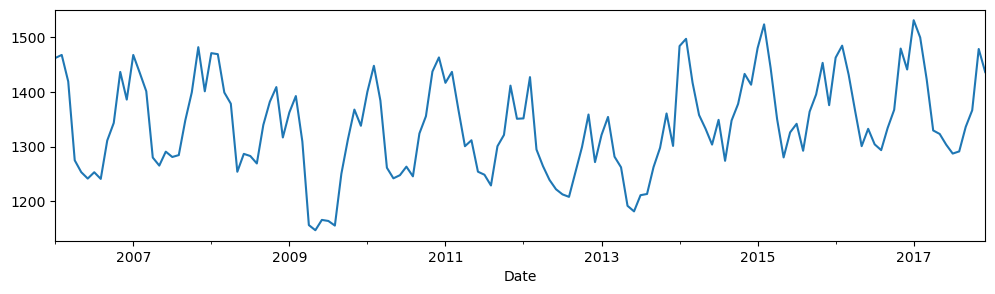

In [11]:
# Plot the time series
ts.plot();

C:\Users\bandi\AppData\Local\Temp\ipykernel_13692\1446163818.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


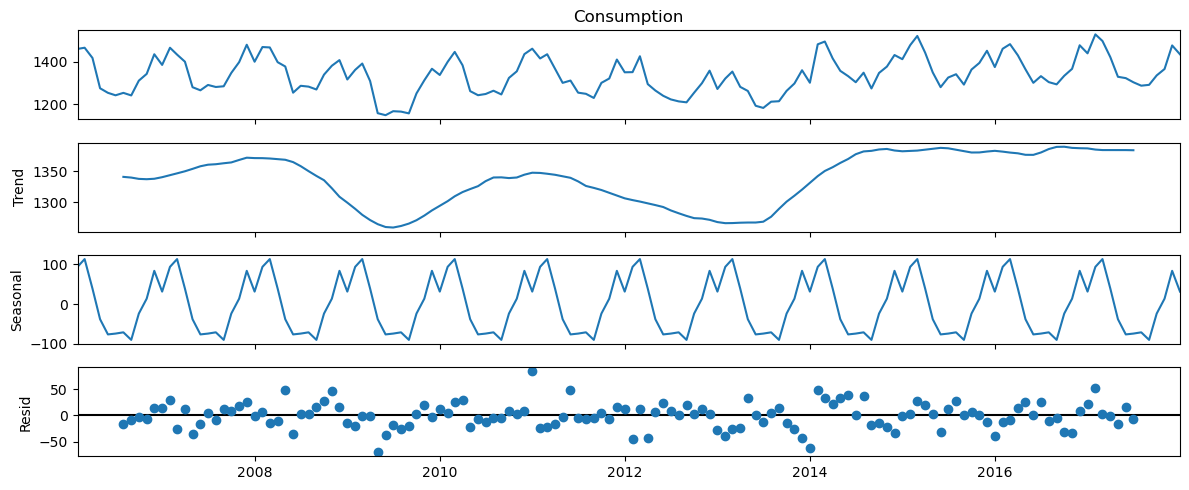

In [12]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [13]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 202.8199389305879 which is ~52.99% of the variation in time series.


In [14]:
# check for nonseasonal differencing
d = ndiffs(ts)
print(f'd = {d}')

d = 0


In [15]:
# check for seasonal differencing
D = nsdiffs(ts, m = 12)
print(f'D = {D}')

D = 0


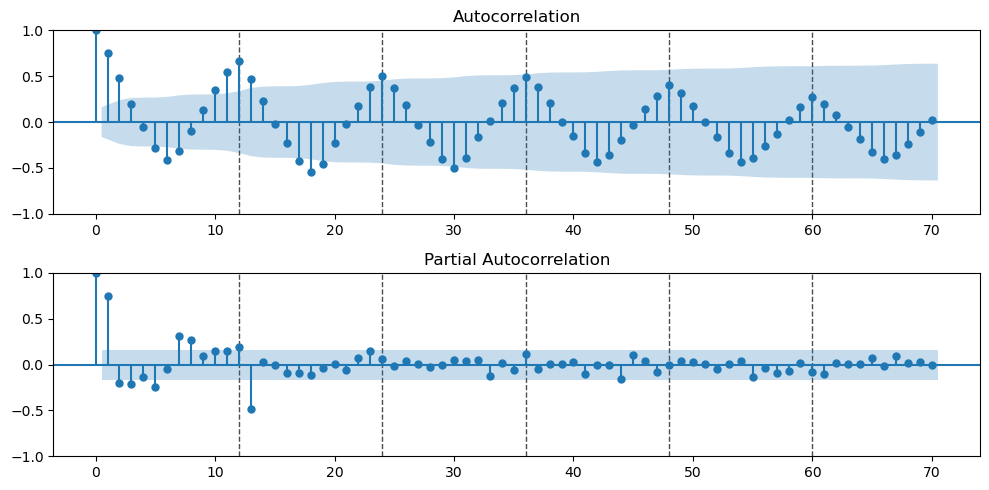

In [16]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts, annotate_seas=True, m = 12, nlags = 70);

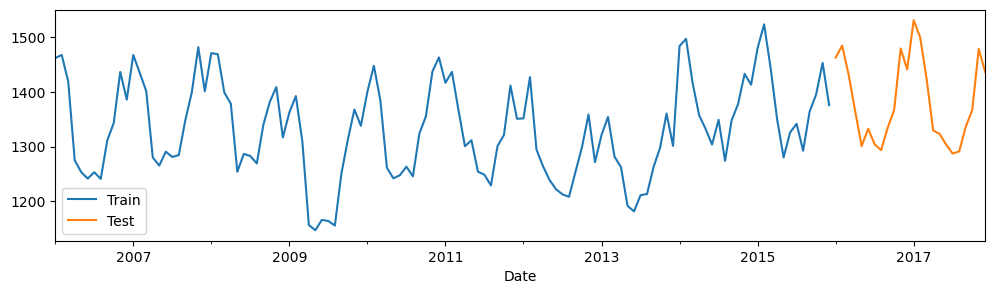

In [17]:
# tts using test size equal to 24 lags
test_lags = 24
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### Run an ARIMA model

In [18]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Define and fit the model
arima = tsa.ARIMA(train, order=(p,d,q)).fit()

# Obtain summary
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  120
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -653.886
Date:                Wed, 03 Apr 2024   AIC                           1313.773
Time:                        13:36:25   BIC                           1322.135
Sample:                    01-31-2006   HQIC                          1317.169
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1334.9675     20.412     65.401      0.000    1294.961    1374.974
ar.L1          0.7558      0.074     10.171      0.000       0.610       0.901
sigma2      3143.5980    412.704      7.617      0.000    2334.713    3952.484
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.12   Prob(JB):                         0.99
Heteroskedasticity (H):               0.87   Skew:                             0.02
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

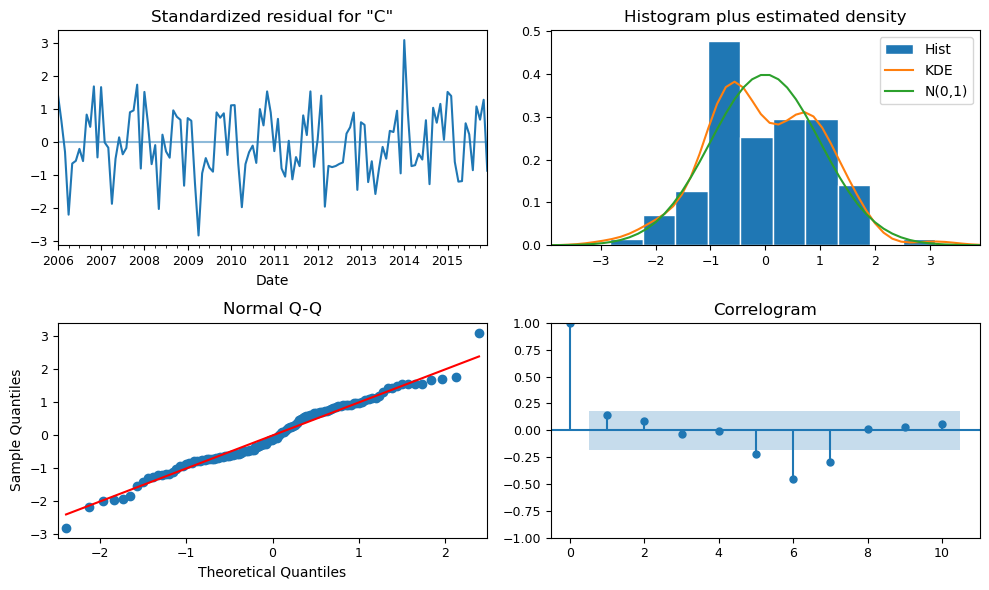

In [19]:
# Obtain diagnostic plots
fig = arima.plot_diagnostics()
fig.set_size_inches(10, 6)

# Adjust the text and title size for each subplot
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=12)  # Reduce the title font size
    ax.tick_params(axis='x', labelsize=9)  # Reduce the x-axis label size
    ax.tick_params(axis='y', labelsize=9)  # Reduce the y-axis label size

fig.tight_layout()
plt.show()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 66.492
- MSE = 7,412.715
- RMSE = 86.097
- R^2 = -0.279
- MAPE = 4.63%


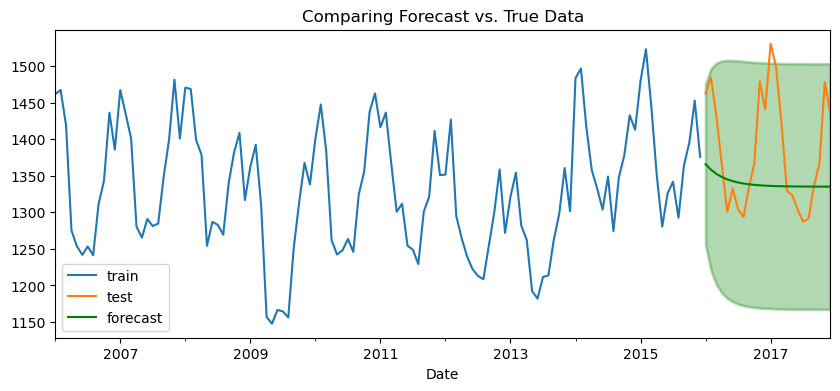

In [20]:
# Obtain summary of forecast as dataframe
forecast_df = arima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

# Obtain regression metrics
regression_metrics_ts(test, forecast_df['mean'])

* Visualization of the forecast against the actual test data indicates that the model fails to capture the seasonal fluctuations which are characteristic of the energy consumption data.

### Fitting a SARIMA Model

In [21]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

# Define and fit the model
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -602.870
Date:                            Wed, 03 Apr 2024   AIC                           1215.739
Time:                                    13:36:39   BIC                           1229.677
Sample:                                01-31-2006   HQIC                          1221.399
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.7459     57.851     23.003      0.000    1217.361    1444.131
ar.L1          0.7880      0.058     13.540      0.000       0.674       0.902
ar.S.L12       0.9954      0.011     91.930      0.000       0.974       1.017
ma.S.L12      -0.8622      0.157     -5.478      0.000      -1.171      -0.554
sigma2      1088.4188    201.853      5.392      0.000     692.794    1484.044
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                23.65
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

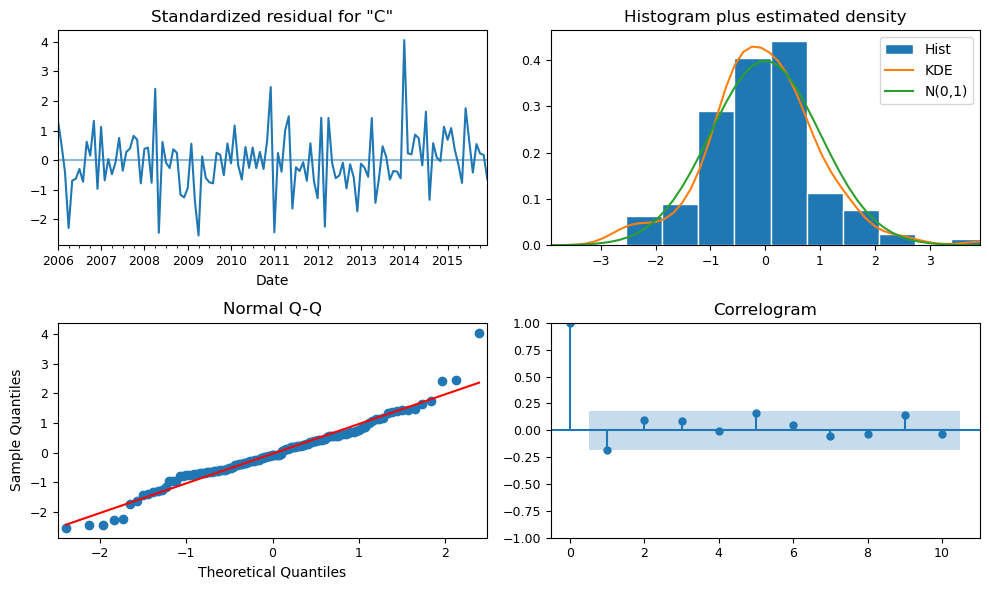

In [22]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10, 6)

# Adjust the text and title size for each subplot
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=12)  # Reduce the title font size
    ax.tick_params(axis='x', labelsize=9)  # Reduce the x-axis label size
    ax.tick_params(axis='y', labelsize=9)  # Reduce the y-axis label size

fig.tight_layout()
plt.show()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.242
- MSE = 2,688.650
- RMSE = 51.852
- R^2 = 0.536
- MAPE = 3.30%


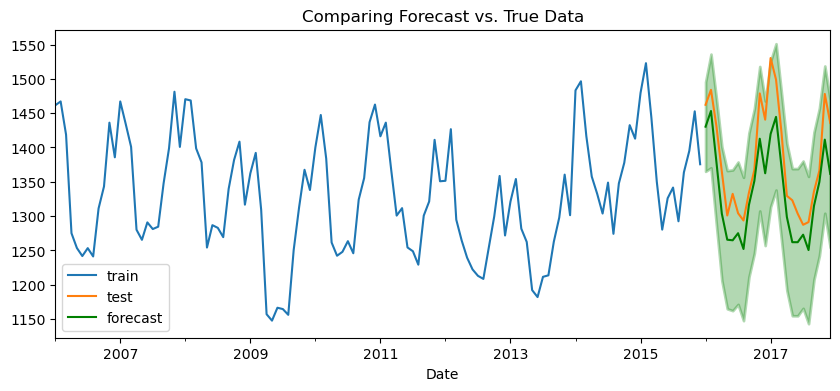

In [23]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

# Obtain regression metrics
regression_metrics_ts(test, forecast_df['mean'])

* The seasonal model follows the general seasonal cycles. Visually, the forecast closely overlaps the test data. 
* The seasonal model also has lower AIC score and preferred values for regression metrics.

## Gridsearch (Practice)

* Tune with pmdarima's auto_arima
* Fit a model on training data with the best parameters from auto_arima
* Plot the forecasts versus the test data
* Obtain metrics for evaluation
* Make forecasts with the auto_arima model
* Select a final model

In [24]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1250.336, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1411.678, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1264.720, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1303.150, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2069.451, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1249.109, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1250.773, Time=0.72 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=1254.012, Time=0.18 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=1254.232, Time=0.38 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1

In [25]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 0, 1)
(1, 0, 0, 12)


In [30]:
# Use auto_arima parameters to fit an ARIMA
auto_sarima = tsa.ARIMA(train, order=auto_model.order, seasonal_order=auto_model.seasonal_order).fit()

# Obtain summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -610.218
Date:                           Wed, 03 Apr 2024   AIC                           1230.436
Time:                                   14:18:24   BIC                           1244.373
Sample:                               01-31-2006   HQIC                          1236.096
                                    - 12-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.6537     60.650     21.940      0.000    1211.782    1449.525
ar.L1          0.8529      0.066     12.972      0.000       0.724       0.982
ma.L1         -0.1856      0.122     -1.526      0.127      -0.424       0.053
ar.S.L12       0.7791      0.062     12.502      0.000       0.657       0.901
sigma2      1378.4991    119.491     11.536      0.000    1144.301    1612.697
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                51.14
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.33
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

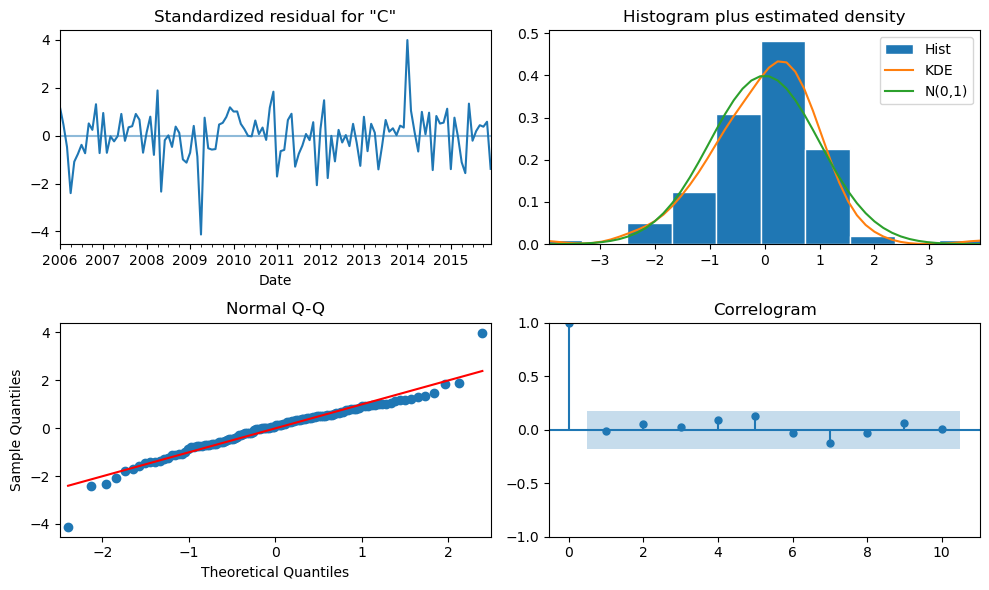

In [31]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 32.589
- MSE = 1,880.944
- RMSE = 43.370
- R^2 = 0.675
- MAPE = 2.29%


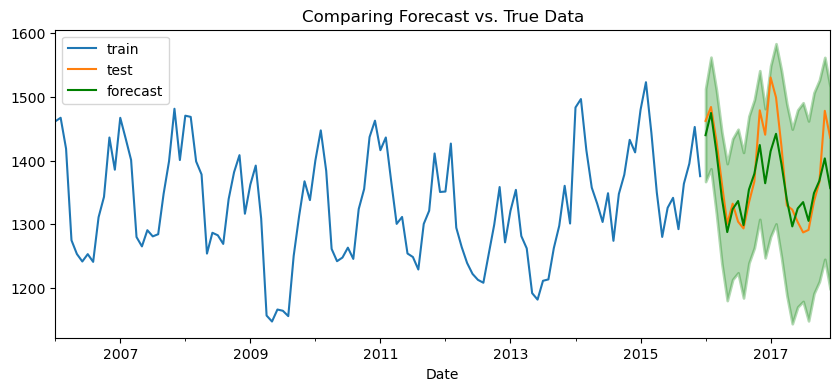

In [32]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [39]:
# Define the data for the comparison as dictionaries
initial_model_metrics = {
    'MAE': 46.242,
    'MSE': 2688.650,
    'RMSE': 51.852,
    'R²': 0.536,
    'MAPE': '3.30%',
    'AIC': 1215,
    'BIC': 1229
}

auto_model_metrics = {
    'MAE': 32.589,
    'MSE': 1880.944,
    'RMSE': 43.370,
    'R²': 0.675,
    'MAPE': '2.29%',
    'AIC': 1230,
    'BIC': 1244
}

column_names = {
    'Initial Model': 'Initial Model (1,0,0)(1,0,1,12)',
    'Auto Model': 'Auto Model (1,0,1)(1,0,0,12)'
}

# Create a DataFrame from the dictionaries
comparison_df = pd.DataFrame({
    column_names['Initial Model']: initial_model_metrics,
    column_names['Auto Model']: auto_model_metrics
})

# Display the DataFrame
comparison_df.T

,MAE,MSE,RMSE,R²,MAPE,AIC,BIC
"Initial Model (1,0,0)(1,0,1,12)",46.242,2688.65,51.852,0.536,3.30%,1215,1229
"Auto Model (1,0,1)(1,0,0,12)",32.589,1880.944,43.37,0.675,2.29%,1230,1244


The preferred choice is the (1,0,1)(1,0,0,12) model recommended by the auto arima. 
* It has better regression metrics such as higher R², lower MAE, MSE, RMSE and MAPE.
* The AIC and BIC scores are slighlty higher than the initial model, but the difference is relatively small.